# Udacity 机器学习(进阶)毕业项目

## 走神司机识别

### 第1步：数据探索
#### 进行数据的统计学分析

In [1]:
from sklearn.datasets import load_files, load_sample_images
from keras.utils import np_utils
import os
import numpy as np
from glob import glob
from preprocess import *
import random
from pprint import pprint

random.seed(876543)

#定义函数来加载train和test数据集
def load_datasets(path):
    '''
    加载给定的路径目录下的文件，
    以每个文件夹名字为target name并将其下的文件归入该target类别，
    train_files, test_flies：是包含了图像的文件路径的numpy数组
    train_targets, test_targets：是包含了分类标签经过独热编码后的numpy数组
    target是独热编码后的numpy数组
    '''
    data = load_files(path)
    files = np.array(data['filenames'])
    print(files)
    print(data['target'])
    targets = np_utils.to_categorical(np.array(data['target']),10)
    return files, targets

root_path = "../../data/distracted_driver_detection/unzip_data/imgs/"

#加载train和test数据集
train_files, train_targets = load_datasets(root_path + 'train')
test_files, test_targets = load_datasets(root_path + 'test')
#os.listdir：输出的文件名不包括"images/test"
#glob：输出的文件名包括"images/test"
#为了与load_datasets的输出保持一致，这里使用glob
#test_files = np.array(os.listdir('images/test2/test/'))
#test_files = np.array(glob('images/test2/test/*'))
driver_status = [item[13:-1] for item in sorted(glob("images/train/*/"))]

print(driver_status)
#打印数据的统计描述
print("There are %d total driver status." % len(driver_status))
print("There are %d total driver images.\n" % len(np.hstack([train_files, test_files])))

print("There are %d total train driver images." % len(train_files))
print("There are %d total test driver images." % len(test_files))

#print(train_files)
print(train_targets)
# print(test_files)
#print(driver_status)

/data/wanlijia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['../../data/distracted_driver_detection/unzip_data/imgs/train/c9/img_54.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/train/c1/img_94750.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/train/c9/img_90465.jpg'
 ...
 '../../data/distracted_driver_detection/unzip_data/imgs/train/c4/img_2632.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/train/c4/img_62157.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/train/c1/img_18002.jpg']
[9 1 9 ... 4 4 1]
['../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_48438.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_49454.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_94120.jpg'
 ...
 '../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_57211.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_58315.jpg'
 '../../data/distracted_driver_detection/unzip_data/imgs/test/test/img_86805.jp

#### 进行数据的可视化
训练集中有22424张照片，已经按照类别将图片分类好了，下面统计了在训练数据中每种类型的样本数量，从统计结果来看，每种状态下的样本数量基本相同，在2000～2500张照片左右；测试集有79721张图片。图片的尺寸都是640*480。

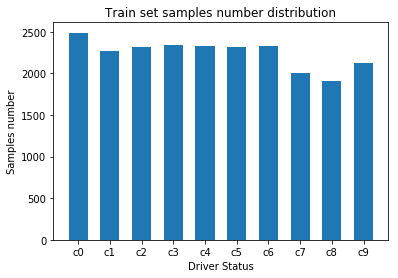

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
train_class_sample_num=[]

for n_class_dir in sorted(glob(root_path + "train/*/")):
    sample_num = len(glob(n_class_dir+'*'))
    train_class_sample_num.append(sample_num)
    
ind = np.arange(len(driver_status))
plt.bar(ind, train_class_sample_num, 0.6)
plt.xlabel('Driver Status')
plt.ylabel('Samples number')
plt.xticks(ind,driver_status)
plt.title('Train set samples number distribution')
plt.show()



项目还提供了一张与训练集图片对应的subject (driver) id，和class id的表格，从该表格中可以得到每个司机在不同分类中的数量。从下面的统计结果来看，p050,p051,p072号司机的状态分布与其他的有所不同，且各占总样本数量的3.5%，4.1%，1.5%，数量比较少在后面的训练中可以考虑去除。

/data/wanlijia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


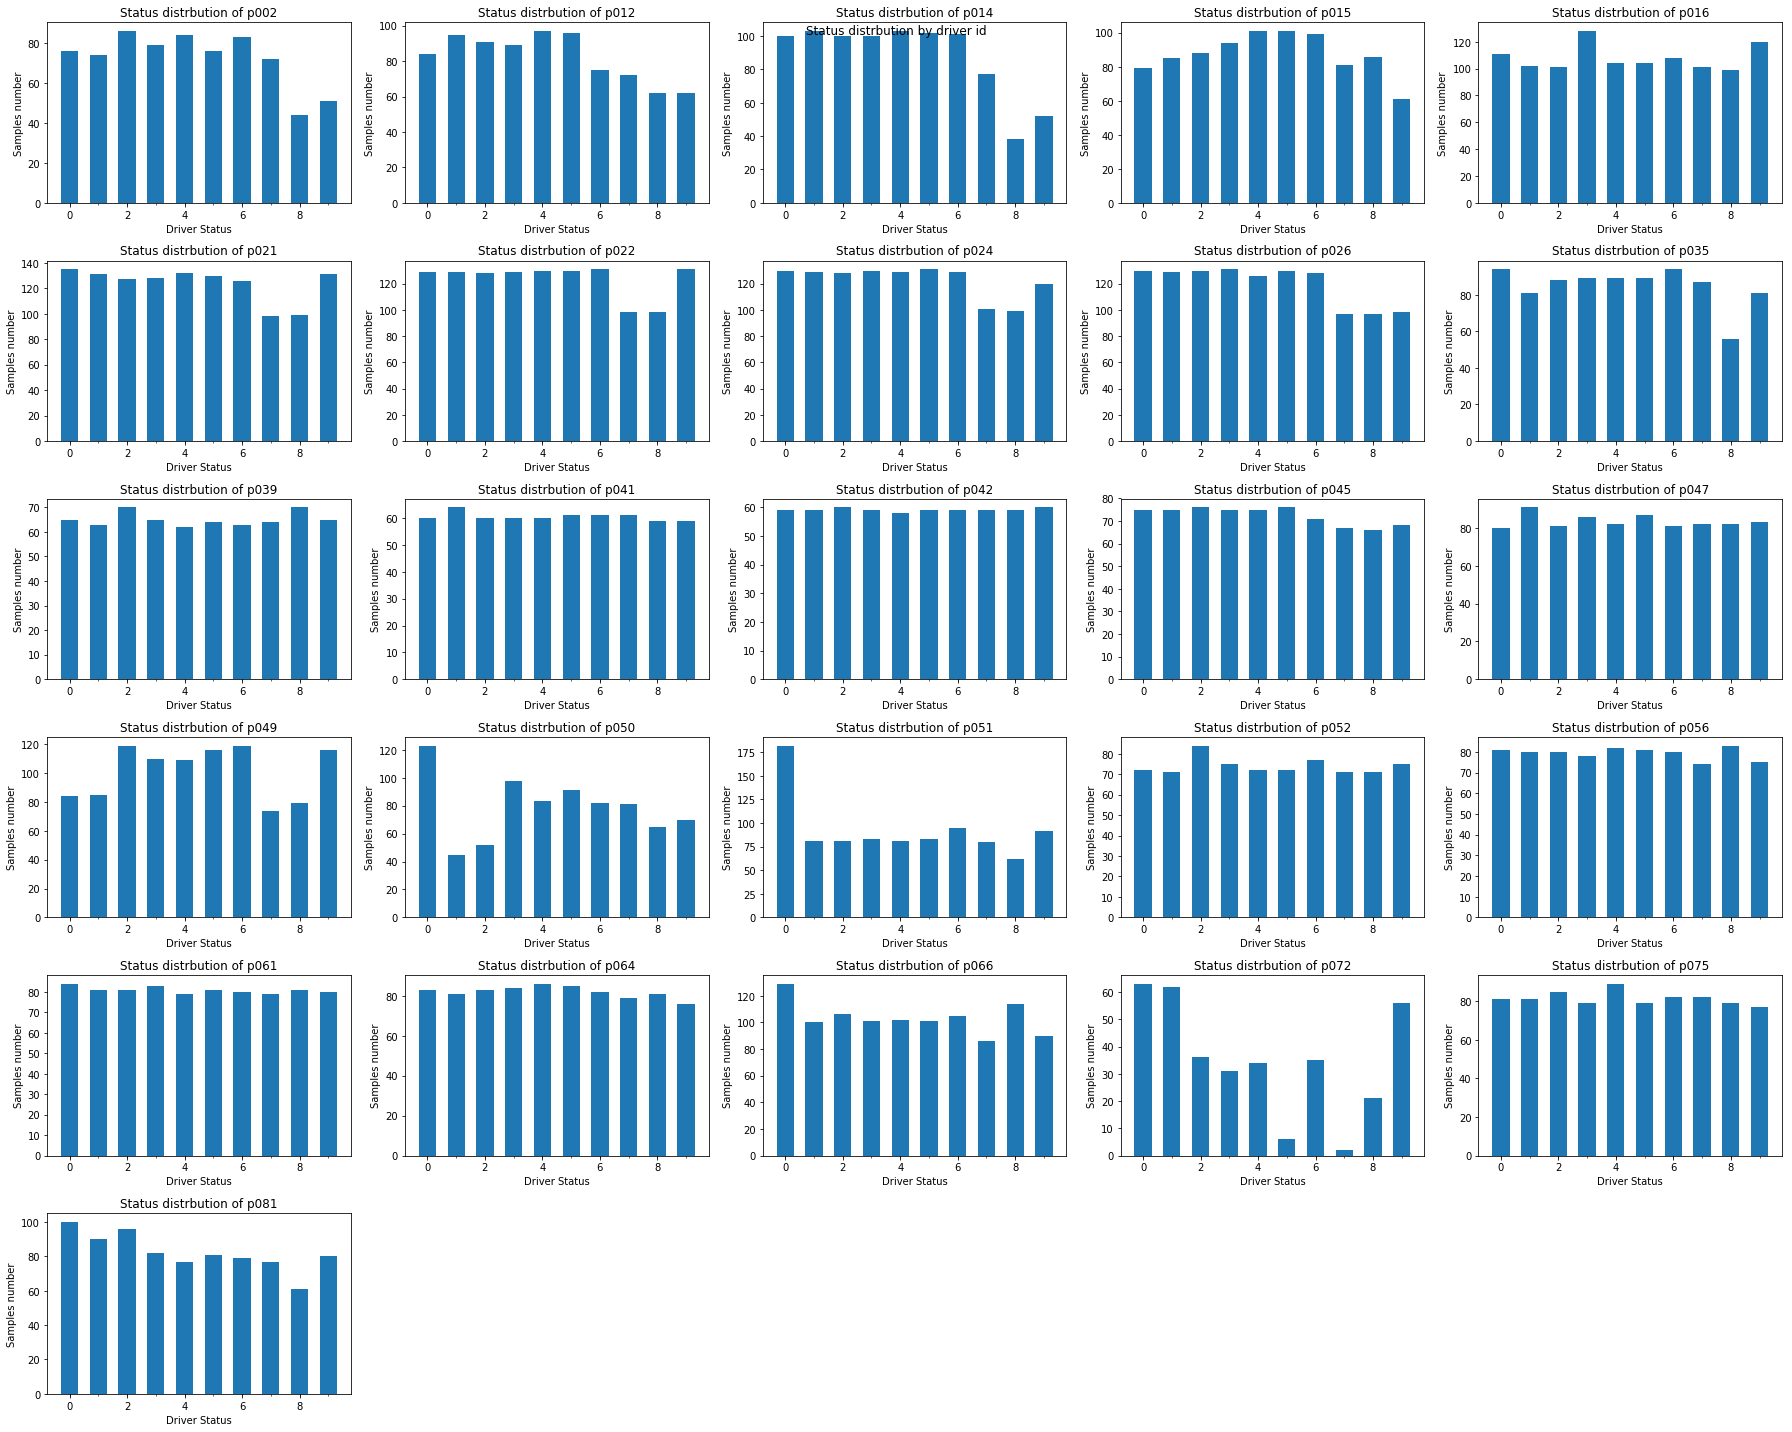

In [3]:
import pandas as pd

driver_list_data = pd.read_csv('driver_imgs_list.csv')

#司机编号
driver_id = []

#所有样本数量
sample_num = driver_list_data['subject'].size

for i in range(sample_num):
    if not driver_list_data['subject'][i] in driver_id:
        driver_id.append(driver_list_data['subject'][i])
fig = plt.figure(figsize=(25,20))
for i in range(len(driver_id)):
    ax=fig.add_subplot(6,5,i+1)
    #表示每种状态下的样本数量
    sample_num_temp = []
    for class_name in driver_status:
        sample_num_temp.append(driver_list_data[(driver_list_data.subject == driver_id[i]) & (driver_list_data.classname == class_name)].shape[0])
    ax.bar(ind, sample_num_temp, 0.6)
    ax.set_xlabel('Driver Status')
    ax.set_ylabel('Samples number')
    ax.set_xticks(ind,driver_status)
    ax.set_title('Status distrbution of %s'%(driver_id[i]))
fig.suptitle('Status distrbution by driver id')
fig.tight_layout()
fig.show()
#print(driver_list_data[(driver_list_data.subject == 'p050')].shape[0]/sample_num)
#print(driver_list_data[(driver_list_data.subject == 'p051')].shape[0]/sample_num)
#print(driver_list_data[(driver_list_data.subject == 'p072')].shape[0]/sample_num)

### 第2步：建立模型
#### 实现一个简单的CNN网络
- 本项目采用巻积神经网络来识别司机的状态，采用keras框架，Tensorlow作为后端来搭建CNN网络。CNN的输入是一个4维张量，为(n_samples, rows, columns, channels)。其中n_samples表示样本的总数，rows, columns和channels分别表示图像的行数、列数和通道数。
- 下面是将图片进行预处理，转化为CNN网络的输入。


In [4]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path, img_nrows = None, img_ncols = None):
    # 用PIL加载RGB图像为PIL.Image.Image类型,将图像尺寸缩放到target_size
    #img_nrows,img_ncols: Either NULL (default to original size) or integer vector (img_height, img_width).
    img = image.load_img(img_path, target_size = (img_nrows,img_ncols))
    # 将PIL.Image.Image类型转化为格式为(img_nrows,img_ncols, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, target_size, 3)的4维张量并返回
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths, img_nrows = None, img_ncols = None):
    list_of_tensor = [path_to_tensor(img_path, img_nrows, img_ncols) for img_path in tqdm(img_paths)]
    #返回(n_samples, target_size, 3)的4维张量
    return np.vstack(list_of_tensor)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rescale = 1/255)
help(gen.flow_from_directory)

Help on method flow_from_directory in module keras_preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest') method of keras_preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    # Arguments
        directory: Path to the target directory.
            It should contain one subdirectory per class.
            Any PNG, JPG, BMP, PPM or TIF images
            inside each of the subdirectories directory tree
            will be included in the generator.
            See [this script](
            https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
            for more details.
        target_size: Tuple of integers `(height, width)`,
            default: `(256, 256)`.
        

In [5]:
#读取图像得到tensor，并进行归一化处理
from preprocess import *
from sklearn.utils import shuffle

train_tensors = paths_to_tensor(train_files,img_nrows = 224, img_ncols = 224).astype('float32')/255

from keras.preprocessing.image import ImageDataGenerator
 
gen = ImageDataGenerator(rescale = 1/255)
print(root_path + 'test')
test_generator = gen.flow_from_directory(root_path + 'test', (224,224), shuffle=False, batch_size=32)
test_file_names = test_generator.filenames

print(train_tensors.shape[1:])
print(test_generator)
#print(train_targets)
# print(test_file_names)


100%|██████████| 22424/22424 [01:36<00:00, 231.26it/s]


../../data/distracted_driver_detection/unzip_data/imgs/test
Found 79726 images belonging to 1 classes.
(224, 224, 3)


In [6]:
#这里的模型结构参考了P5的dog project中推荐的CNN网络家架构。主要目的是为了验证整个程序的流程是否正确。
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

simple_model = Sequential()
simple_model.add(Conv2D(filters = 16, kernel_size=(2,2),strides=(1,1), padding='valid', input_shape = train_tensors.shape[1:]))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(Conv2D(filters = 32, kernel_size=(2,2),strides=(1,1), padding='valid'))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(Conv2D(filters = 64, kernel_size=(2,2),strides=(1,1), padding='valid'))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(GlobalAveragePooling2D())
simple_model.add(Dropout(rate=0.5))
simple_model.add(Dense(10,activation='softmax'))
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [12]:
#from keras.utils import multi_gpu_model
#simple_parallel_model = multi_gpu_model(simple_model, gpus=2)
#编译模型
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#simple_parallel_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# 画出模型的结构图
from keras.utils import plot_model
import pydot
plot_model(simple_model, to_file='simple_model.png',show_shapes = True)

In [14]:
#下面使用model checkpointing来存储具有最低验证集loss的模型，并将训练过程中的
from keras.callbacks import ModelCheckpoint, CSVLogger

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_best_models/simple_model_best_weights.hdf5', 
                               verbose=1, save_best_only=True)
csv_logger = CSVLogger('log/simple_model_fit.log')
simple_model.fit(train_tensors, train_targets, 
          validation_split=0.2,shuffle=True,
          epochs=epochs, batch_size=20, callbacks=[checkpointer,csv_logger], verbose=1)


Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 148s 8ms/step - loss: 2.3023 - acc: 0.1102 - val_loss: 2.2981 - val_acc: 0.1133

Epoch 00001: val_loss improved from inf to 2.29813, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 2/10
 3660/17939 [=====>........................] - ETA: 1:47 - loss: 2.2983 - acc: 0.1096

KeyboardInterrupt: 

/data/wanlijia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


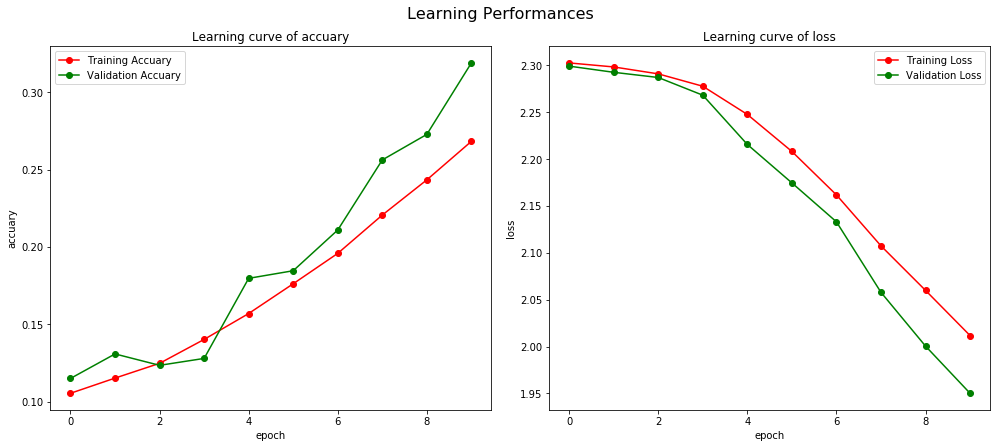

In [27]:
#画出学习曲线
import visuals as vs
vs.ModelLearning('log/simple_model_fit.log')


In [28]:
#加载具有最佳验证集loss的模型权重
simple_model.load_weights('saved_best_models/simple_model_best_weights.hdf5')

In [29]:
#生成可提交的submission file
from submission import *

simple_model_predictions = simple_model.predict_generator(test_generator, len(test_generator),verbose=1)
create_submission('simple_model',simple_model_predictions, root_path)

Found 0 images belonging to 0 classes.


#### 使用迁移学习
从上面的结果来看，simple model这个简单的CNN网络架构并不能实现很好的结果。主要是从学习曲线可以看出模型处于underfitting状态。
这里采用迁移学习来实现更大的网络结构

In [8]:
#利用迁移模型创建一个CNN网络
from preprocess import *
get_bottleneck_features_from_ResNet50(root_path)
#get_bottleneck_features_from_InceptionV3('images')
#get_bottleneck_features_from_Xception('images')
#get_bottleneck_features_from_InceptionResNetV2('images')

Found 22424 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


/data/wanlijia/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


载入特征向量

In [9]:
import h5py
from sklearn.utils import shuffle
np.random.seed(5000)

print(root_path)

with h5py.File('ResNet50.h5') as f:
    train_data = np.array(f['train'])
    test_data = np.array(f['test'])
    target_data = np_utils.to_categorical(np.array(f['target']),10)
    
train_ResNet50,target_ResNet50 = shuffle(train_data, target_data)
test_ResNet50 = test_data
    

print(train_ResNet50[0].shape)
# print(train_ResNet50.shape)
# print(train_ResNet50.shape[1:])
print(len(train_ResNet50))
print(test_data.shape)
# print(target_ResNet50)
# print(train_targets)

../../data/distracted_driver_detection/unzip_data/imgs/
(7, 7, 2048)
22424
(79726, 7, 7, 2048)


构建模型

In [31]:
from keras.models import *
from keras.layers import *

np.random.seed(5000)

from keras import optimizers

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06)

model_params_dict = dict(
    optimizer=rmsprop, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

#input_tensor = Input(train_ResNet50.shape[1:])
#x = Dropout(0.5)(input_tensor)
#x = Dense(10,activation = 'sigmoid')(x)
#resnet50_model = Model(input_tensor,x)
#resnet50_model.summary()

resnet50_model = Sequential()
resnet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
resnet50_model.add(Dropout(rate=0.5))
resnet50_model.add(Dense(10, activation='softmax'))

resnet50_model.summary()
resnet50_model.compile(**model_params_dict)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [32]:
## 训练模型
from keras.callbacks import ModelCheckpoint, CSVLogger

epochs = 20
best_model_path = 'saved_best_models/my_resnet50_adam_model_best_weights.hdf5'
best_model_log_path = 'log/resnet50_adam_model_fit.log'

checkpointer = ModelCheckpoint(filepath=best_model_path, 
                               verbose=1, save_best_only=True)
csv_logger = CSVLogger(best_model_log_path)
#print(target_ResNet50)
resnet50_model.fit(train_ResNet50, target_ResNet50, 
          validation_split=0.2,shuffle=True,
          epochs=epochs, batch_size=128, callbacks=[checkpointer,csv_logger], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/20
17939/17939 [==============================] - 7s 410us/step - loss: 2.8719 - acc: 0.1446 - val_loss: 1.9116 - val_acc: 0.3576

Epoch 00001: val_loss improved from inf to 1.91165, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 2/20
17939/17939 [==============================] - 5s 251us/step - loss: 2.3644 - acc: 0.2284 - val_loss: 1.5665 - val_acc: 0.5472

Epoch 00002: val_loss improved from 1.91165 to 1.56649, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 3/20
17939/17939 [==============================] - 6s 316us/step - loss: 1.9791 - acc: 0.3252 - val_loss: 1.3008 - val_acc: 0.6847

Epoch 00003: val_loss improved from 1.56649 to 1.30076, saving model to saved_best_models/my_resnet50_adam_model_best_weights.hdf5
Epoch 4/20
17939/17939 [==============================] - 4s 234us/step - loss: 1.6920 - acc: 0.4167 - val_loss: 1.1142 - val_acc: 0.7382

Epoch 

In [33]:
## 加载具有最好验证loss的模型

resnet50_model.load_weights('saved_best_models/my_resnet50_adam_model_best_weights.hdf5')


/data/wanlijia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


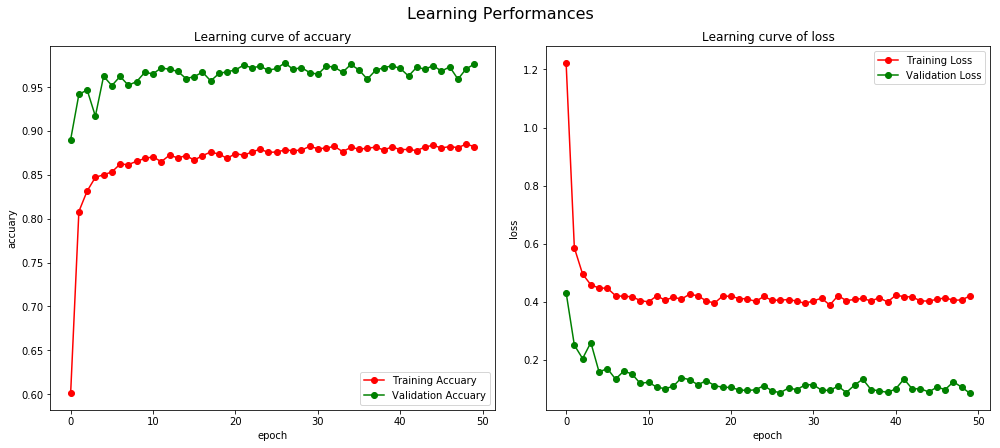

In [34]:
import visuals as vs
#使用adam优化起
vs.ModelLearning('log/resnet50_adam_model_training.log')

In [35]:
print("start prediction")
resnet50_model_predictions = resnet50_model.predict(test_ResNet50, verbose=1)
print("complete prediction")
# print(y_pred)

start prediction
79726/79726 [==============================] - 24s 305us/step
complete prediction


In [36]:
#生成可提交的submission file
from submission import *
create_submission('resnet50_model',resnet50_model_predictions, root_path)

Found 79726 images belonging to 1 classes.
